In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

In [2]:
train = pd.read_csv('/content/drive/MyDrive/machinelearning/SMAPE/train.csv')
test = pd.read_csv("/content/drive/MyDrive/machinelearning/SMAPE/test.csv")
building_info = pd.read_csv("/content/drive/MyDrive/machinelearning/SMAPE/building_info.csv")

train 데이터 전처리

In [3]:
train = train.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
train.drop('num_date_time', axis = 1, inplace=True)

In [4]:
test = test.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
test.drop('num_date_time', axis = 1, inplace=True)

In [5]:
building_info = building_info.rename(columns={
    '건물번호': 'building_number',
    '건물유형': 'building_type',
    '연면적(m2)': 'total_area',
    '냉방면적(m2)': 'cooling_area',
    '태양광용량(kW)': 'solar_power_capacity',
    'ESS저장용량(kWh)': 'ess_capacity',
    'PCS용량(kW)': 'pcs_capacity'
})

In [6]:
translation_dict = {
    '건물기타': 'Other Buildings',
    '공공': 'Public',
    '대학교': 'University',
    '데이터센터': 'Data Center',
    '백화점및아울렛': 'Department Store and Outlet',
    '병원': 'Hospital',
    '상용': 'Commercial',
    '아파트': 'Apartment',
    '연구소': 'Research Institute',
    '지식산업센터': 'Knowledge Industry Center',
    '할인마트': 'Discount Mart',
    '호텔및리조트': 'Hotel and Resort'
}

building_info['building_type'] = building_info['building_type'].replace(translation_dict)

In [7]:
train = pd.merge(train, building_info, on='building_number', how='left')
test = pd.merge(test, building_info, on='building_number', how='left')

In [8]:
train = train.drop(['solar_power_capacity', 'ess_capacity', 'pcs_capacity'], axis=1)
test = test.drop(['solar_power_capacity', 'ess_capacity', 'pcs_capacity'], axis=1)

In [9]:
train['date_time'] = pd.to_datetime(train['date_time'], format='%Y%m%d %H')

train['hour'] = train['date_time'].dt.hour
train['day'] = train['date_time'].dt.day
train['month'] = train['date_time'].dt.month
train['week'] = train['date_time'].dt.weekofyear
train['holiday'] = train.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)

train['sin_time'] = np.sin(2*np.pi*train.hour/24)
train['cos_time'] = np.cos(2*np.pi*train.hour/24)

<ipython-input-9-30c0c5042a9a>:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train['week'] = train['date_time'].dt.weekofyear


In [10]:
train['THI'] = 9/5*train['temperature'] - 0.55*(1-train['humidity']/100)*(9/5*train['humidity']-26)+32

In [11]:
def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

cdhs = np.array([])
for num in range(1,101,1):
    temp = train[train['building_number'] == num]
    cdh = CDH(temp['temperature'].values)
    cdhs = np.concatenate([cdhs, cdh])
train['CDH'] = cdhs

train.drop(['solar_radiation','hour'], axis = 1, inplace = True)
train

,building_number,date_time,temperature,rainfall,windspeed,humidity,sunshine,power_consumption,building_type,total_area,cooling_area,day,month,week,holiday,sin_time,cos_time,THI,CDH
0,1,2022-06-01 00:00:00,18.6,NaN,0.9,42.0,NaN,1085.28,Other Buildings,110634.00,39570.00,1,6,22,0,0.000000,1.000000,49.6576,-7.4
1,1,2022-06-01 01:00:00,18.0,NaN,1.1,45.0,NaN,1047.36,Other Buildings,110634.00,39570.00,1,6,22,0,0.258819,0.965926,47.7625,-15.4
2,1,2022-06-01 02:00:00,17.7,NaN,1.5,45.0,NaN,974.88,Other Buildings,110634.00,39570.00,1,6,22,0,0.500000,0.866025,47.2225,-23.7
3,1,2022-06-01 03:00:00,16.7,NaN,1.4,48.0,NaN,953.76,Other Buildings,110634.00,39570.00,1,6,22,0,0.707107,0.707107,44.7856,-33.0
4,1,2022-06-01 04:00:00,18.4,NaN,2.8,43.0,NaN,986.40,Other Buildings,110634.00,39570.00,1,6,22,0,0.866025,0.500000,49.0061,-40.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,2022-08-24 19:00:00,23.1,NaN,0.9,86.0,0.5,881.04,Hotel and Resort,57497.84,40035.23,24,8,34,1,-0.965926,0.258819,63.6624,-19.6
203996,100,2022-08-24 20:00:00,22.4,NaN,1.3,86.0,0.0,798.96,Hotel and Resort,57497.84,40035.23,24,8,34,1,-0.866025,0.500000,62.4024,-20.2
203997,100,2022-08-24 21:00:00,21.3,NaN,1.0,92.0,NaN,825.12,Hotel and Resort,57497.84,40035.23,24,8,34,1,-0.707107,0.707107,64.1976,-22.3
203998,100,2022-08-24 22:00:00,21.0,NaN,0.3,94.0,NaN,640.08,Hotel and Resort,57497.84,40035.23,24,8,34,1,-0.500000,0.866025,65.0744,-25.1


train data shape: x: (1872, 16), y: (1872,)


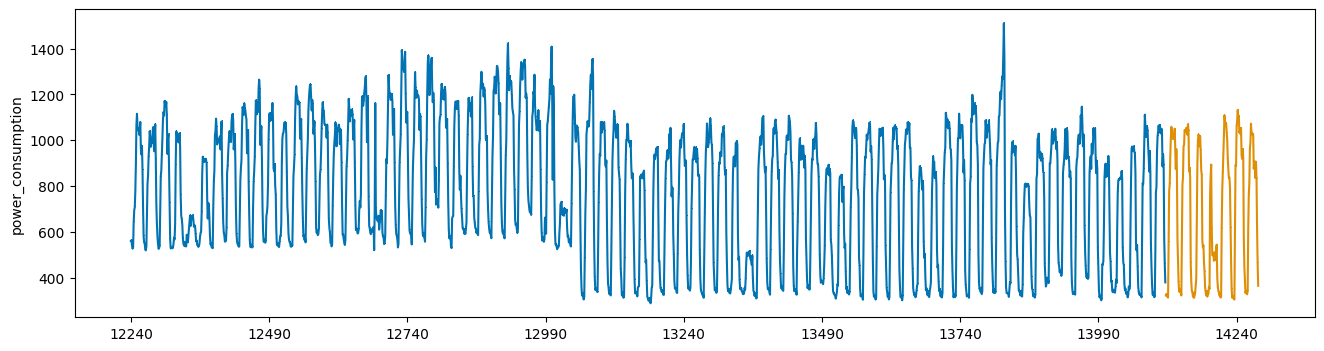

In [12]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series

x = train.loc[train["building_number"] == 7].iloc[:,3:]
y = train.loc[train["building_number"] == 7, 'power_consumption']

y_train, y_valid, x_train, x_valid = temporal_train_test_split(X=x, y=y, test_size=24*7)

print(f"train data shape: x: {x_train.shape}, y: {y_train.shape}")

plot_series(y_train, y_valid, markers=[',', ','])
plt.show()

test 데이터 전처리

In [13]:
test['date_time'] = test['date_time'][1][:11]
date_test = pd.to_datetime(test.date_time)

test['hour'] = date_test.dt.hour
test['day'] = date_test.dt.weekday
test['month'] = date_test.dt.month
test['week'] = date_test.dt.weekofyear

test['THI'] = 9/5*test['temperature'] - 0.55*(1-test['humidity']/100)*(9/5*test['humidity']-26)+32

cdhs = np.array([])
for num in range(1,101,1):
    temp = test[test['building_number'] == num]
    cdh = CDH(temp['temperature'].values)
    cdhs = np.concatenate([cdhs, cdh])
test['CDH'] = cdhs

test['sin_time'] = np.sin(2*np.pi*test.hour/24)
test['cos_time'] = np.cos(2*np.pi*test.hour/24)
test['holiday'] = test.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)

test

<ipython-input-13-fefc4666fdae>:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  test['week'] = date_test.dt.weekofyear


,building_number,date_time,temperature,rainfall,windspeed,humidity,building_type,total_area,cooling_area,hour,day,month,week,THI,CDH,sin_time,cos_time,holiday
0,1,20220825 01,23.5,0.0,2.2,72,Other Buildings,110634.00,39570.00,1,3,8,34,58.3456,-2.5,0.258819,0.965926,0
1,1,20220825 01,23.0,0.0,0.9,72,Other Buildings,110634.00,39570.00,1,3,8,34,57.4456,-5.5,0.258819,0.965926,0
2,1,20220825 01,22.7,0.0,1.5,75,Other Buildings,110634.00,39570.00,1,3,8,34,57.8725,-8.8,0.258819,0.965926,0
3,1,20220825 01,22.1,0.0,1.3,78,Other Buildings,110634.00,39570.00,1,3,8,34,57.9376,-12.7,0.258819,0.965926,0
4,1,20220825 01,21.8,0.0,1.0,77,Other Buildings,110634.00,39570.00,1,3,8,34,56.9961,-16.9,0.258819,0.965926,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,100,20220825 01,22.5,0.0,0.9,84,Hotel and Resort,57497.84,40035.23,1,3,8,34,61.4824,-34.5,0.258819,0.965926,0
16796,100,20220825 01,20.7,0.0,0.4,95,Hotel and Resort,57497.84,40035.23,1,3,8,34,65.2725,-34.4,0.258819,0.965926,0
16797,100,20220825 01,20.2,0.0,0.4,98,Hotel and Resort,57497.84,40035.23,1,3,8,34,66.7056,-35.3,0.258819,0.965926,0
16798,100,20220825 01,20.1,0.0,1.1,97,Hotel and Resort,57497.84,40035.23,1,3,8,34,65.7281,-36.8,0.258819,0.965926,0


XGBoost

In [14]:
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100

In [15]:
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

In [16]:
def train_test_split(train, num, val_hour) :
    y = train.loc[train['building_number'] == num, 'power_consumption']
    x = train.loc[train['building_number'] == num].iloc[:, 2:-1]
    if val_hour == 0 :
        return y, None, x, None
    else :
        y_train, y_valid, x_train, x_valid = temporal_train_test_split(X = x, y = y, test_size =  val_hour)
        print('train data shape\nx:{}, y:{}'.format(x_train.shape, y_train.shape))
        return y_train, y_valid, x_train, x_valid

In [17]:
def pop_feat(train_copy, log = False, train = True) :
  if log and train :
        train_copy['power_consumption'] = np.log(train_copy['power_consumption'])
  return train_copy

In [18]:
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from xgboost import XGBRegressor

def fit_XGB(train, test, num, param=None, seed=0):
  y_train, y_valid, x_train, x_valid = train_test_split(train, num, 24*7)

  min_child_weight = 6
  max_depth = 5
  colsample_bytree = 0.8
  subsample = 0.9
  if param is not None:
    len(param) == 6
    min_child_weight = param.min_child_weight
    max_depth = int(param.max_depth)
    colsample_bytree = param.colsample_bytree
    subsample = param.subsample

  xgb_reg = XGBRegressor(n_estimators =10000, eta = 0.01, min_child_weight = min_child_weight,
                            max_depth = max_depth, colsample_bytree = colsample_bytree,
                            subsample = subsample, seed=seed,  gpu_id = 1, tree_method = 'gpu_hist', predictor= 'gpu_predictor')

  xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)],
              early_stopping_rounds=300,
            verbose=False)

  pred = xgb_reg.predict(x_valid)
  pred = pd.Series(pred)
  pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)

  x_test_i = test[test['building_number'] == 1]
  y_pred_test = xgb_reg.predict(x_test_i.iloc[:,2:])
  test_series = pd.Series(y_pred_test,index = np.arange((y_valid.index.max() + 1), (y_valid.index.max() + 1 + len(y_pred_test))))
  plot_series(y_train, y_valid, pd.Series(pred), test_series, markers=[',' , ',', ',', ',',])
  plt.title(num)
  # os.makedirs(os.path.join(save_path, 'results'), exist_ok = True)
  # plt.savefig(os.path.join(path, 'results', str(num)))
  # plt.show()
  # os.makedirs(os.path.join(save_path, 'results'), exist_ok = True)

  # if log == True :
  #     pred = np.exp(pred)
  #     y_valid = np.exp(y_valid)
  #     y_pred_test = np.exp(y_pred_test)
  smape_val = SMAPE(y_valid, pred)
  r2_val = r2_score(y_valid, pred)
  print('best iterations: {}'.format(xgb_reg.best_iteration))
  print('SMAPE : {}'.format(SMAPE(y_valid, pred)))
  return smape_val, r2_val, y_valid, pred, y_pred_test

In [19]:
grid = {'n_estimators' : [1000], 'eta' : [0.01], 'min_child_weight' : np.arange(1, 8, 1),
        'max_depth' : np.arange(3,9,1) , 'colsample_bytree' :np.arange(0.8, 1.0, 0.1),
        'subsample' :np.arange(0.8, 1.0, 0.1)}

def fit_XGB_gscv(train, test, num):
    y_train, y_valid, x_train, x_valid  = train_test_split(train, num, 168)
    pds = PredefinedSplit(np.append(-np.ones(len(x_train)-168), np.zeros(168)))
    gcv = GridSearchCV(estimator = XGBRegressor(seed = 0, gpu_id = 1,
                                                tree_method = 'gpu_hist', predictor= 'gpu_predictor'),
                       param_grid = grid, scoring =  make_scorer(SMAPE, greater_is_better=False), cv = pds, refit = True, verbose = False)

    gcv.fit(x_train, y_train)
    best = gcv.best_estimator_
    params = gcv.best_params_
    print(params)

    pred = gcv.predict(x_valid)
    pred = pd.Series(pred)
    pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
    # plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])

    # Test
    x_test_i = test[test['building_number'] == 1]
    y_pred_test = gcv.predict(x_test_i.iloc[:,2:])
    test_series = pd.Series(y_pred_test,index = np.arange((y_valid.index.max() + 1), (y_valid.index.max() + 1 + len(y_pred_test))))
    plot_series(y_train, y_valid, pd.Series(pred), test_series, markers=[',' , ',', ',', ',',])
    plt.title(num)
    # os.makedirs(os.path.join(save_path, 'results'), exist_ok = True)
    # plt.savefig(os.path.join(path, 'results', str(num)))
    plt.show()

    # if log == True :
    #     pred = np.exp(pred)
    #     y_valid = np.exp(y_valid)
    #     y_pred_test = np.exp(y_pred_test)
    smape_val = SMAPE(y_valid, pred)
    r2_val = r2_score(y_valid, pred)
    #print('best iterations: {}'.format(gcv.best_iteration))
    print('SMAPE : {}'.format(SMAPE(y_valid, pred)))
    return smape_val, r2_val, y_valid, pred, y_pred_test, params

In [24]:
log = False
train = pop_feat(train, log, True)
test = pop_feat(test, log, False)

In [21]:
pred_val_enss = []
test_enss = []

In [22]:
for seed in range(1) :
    print(seed)
    summary_list = []
    ans_val_list = []
    pred_val_list = []
    pred_test_list = []

    for i in tqdm(range(100)) :
        param_xgb = None
        print(i)
        summary_dict = {}
        smape_val, r2_val, ans_val, pred_val, pred_test = fit_XGB(train, test, i+1, param_xgb, seed)

        summary_dict['building_number'] = i+1
        summary_dict['SMAPE_val'] = smape_val
        summary_dict['R2_val'] = r2_val
        summary_list.append(summary_dict)
        ans_val_list.append(ans_val)
        pred_val_list.append(pred_val)
        pred_test_list.append(pred_test)
    ans_val_whole = np.concatenate(ans_val_list)
    pred_val_whole = np.concatenate(pred_val_list)
    pred_test_whole = np.concatenate(pred_test_list)
    smape_val = SMAPE(ans_val_whole, pred_val_whole)
    df = pd.DataFrame(summary_list)

    pred_val_enss.append(pred_val_whole)
    test_enss.append(pred_test_whole)

0


  0%|          | 0/100 [00:00<?, ?it/s]

0
train data shape
x:(1872, 16), y:(1872,)


ValueError: ignored